In [18]:
import numpy as np
import torch
import nibabel as nib
import matplotlib.pyplot as plt
import importlib
from model.utils import save_pickle, load_pickle
from nilearn.plotting import plot_stat_map

In [19]:
### template
data_path = 'data/NARPS'
mni_img = nib.load(f'{data_path}/group_analysis.ttest.1grp.equalRange.gain/MNI152_2009_template_SSW.nii.gz')
mni_data = mni_img.get_fdata()[:, :, :, 0, 0]  # Extract the 0-th volume
target_affine = mni_img.affine
x,y,z=(mni_data).nonzero()

### mask
mask_path = f'{data_path}/group_analysis.ttest.1grp.equalRange.gain/group_mask.inter.nii.gz'
mask_img = nib.Nifti1Image.from_filename(mask_path)
mask = nib.Nifti1Image.from_filename(mask_path).get_fdata()

In [20]:
### load data
narps = load_pickle('data/NARPS/data.pickle')
data = narps['data']
x,y,z = narps['coord']
S = narps['S']
dtype = torch.float32

Pickle loaded from data/NARPS/data.pickle


In [21]:
from sklearn.gaussian_process.kernels import RBF, Matern
### choose kernel function
ls = 0.1
# kernel = RBF(length_scale=ls)
kernel = Matern(length_scale=ls, nu=1.5)
L = 1200
L_eta = 50
n_chain = 3

In [22]:
import model.BSHE_VI as BSHE_VI
BSHE_VI = importlib.reload(BSHE_VI) 

In [23]:
model = BSHE_VI.BSHE_VI( Y=data, X=None,
    grids=S, kernel=kernel, L = L, L_eta = L_eta,verbose=5000,
    dtype=dtype, ELBO_diff_tol=1e-8,para_diff_tol = 1e-8, elbo_stop=False,max_iter=50000)

In [24]:
paras, profile = model.run()

iter: 0, ELBO: 29408.494140625
iter: 5000, ELBO: 249640.34375
iter: 10000, ELBO: 249640.515625
iter: 15000, ELBO: 249640.671875
Used iter 19069 finished in 36.34 seconds


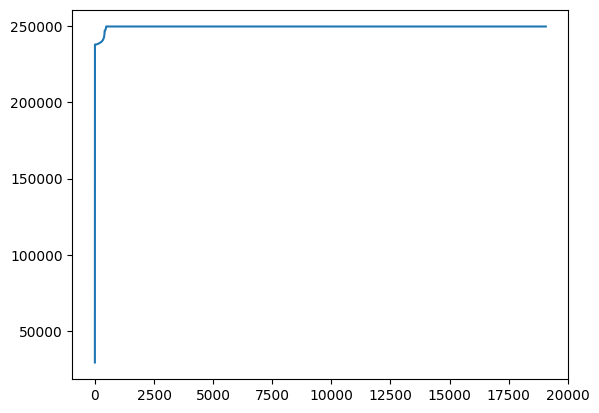

In [25]:
plt.plot(profile['ELBO'])

In [26]:
voxel_mcmc = paras['E_alpha'][:,None] + paras['E_theta_beta'] @ model.basis.t()

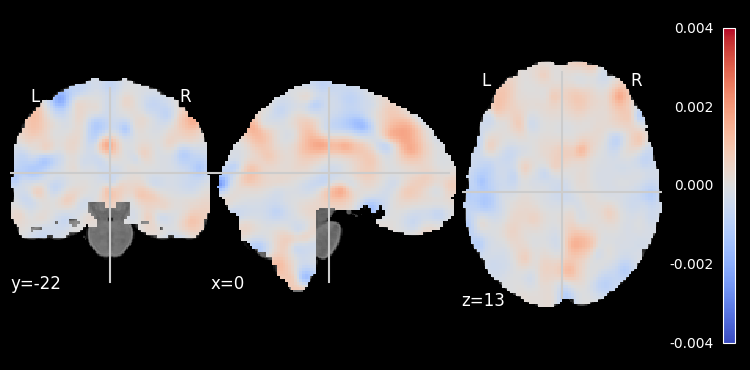

In [27]:
post_map = np.zeros(mask_img.shape)
post_map[x, y, z] = voxel_mcmc[0]
post_map_img = nib.Nifti1Image(post_map, mask_img.affine)
fig=plot_stat_map(post_map_img,
              bg_img=nib.Nifti1Image(mni_data, mni_img.affine),
              colorbar=True,
              threshold=0,
               cbar_tick_format="%.3f",
              #vmax=0.003, vmin=-0.003,
            cmap='coolwarm',
             #cmap = base_cmap,
              cut_coords=[0, -22, 13])



In [28]:
ppc = model.PPC(n_mcmc=50)


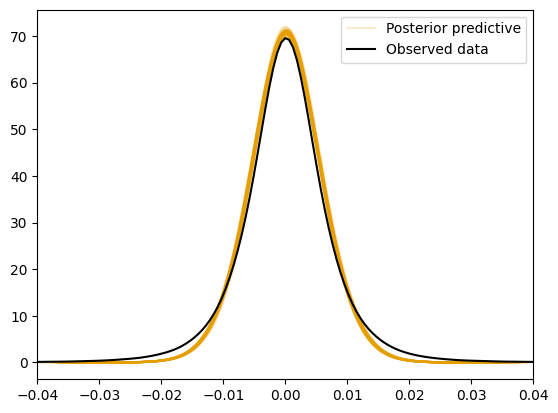

In [29]:
from fastkde import fastKDE
## takes about 9 mins for 300 draws
for i in range(ppc.shape[0]):
    density = fastKDE.pdf(ppc[i].reshape(-1),ecf_precision=1) # flat to vector
    density.plot(alpha=0.2, color="#E69F00", label='Posterior predictive' if i == 0 else None)
data_den= fastKDE.pdf(data.reshape(-1),ecf_precision=1)
data_den.plot(alpha=1.0, color="black", label='Observed data')
plt.xlim(-0.04, 0.04)  
plt.ylabel('')
plt.xlabel('')

# Add legend (only one entry for grey lines)
plt.legend()
#plt.savefig(f'plots/M21_ppc_L{L}.png', dpi=300, bbox_inches='tight')  
plt.show()